<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/draft/Fact_data_ajustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 inamura先生に聞きたいこと \\
 ・けん玉の難易度の変更は何を決め手に決定しているのか？ \\
 ・変更なしと変更ありの被験者番号は同一人物なのか？ \\


In [1]:
# GoogleドライブをGoogle Colabにマウント
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [2]:
#pandasをインポート
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'

In [6]:
class Kendama_analyze():
  def __init__(self, original_pattern, number_people):
    self.original_pattern = original_pattern #ファイルのリンクを格納
    self.number_people = number_people #どれだけのデータ数を使用するかを決定する変数
    self.threshold = {
        'easy': 0.092,
        'normal': 0.07,
        'hard' : 0.048
    }

  #被験者一人の解析を行う関数
  def start_analyze(self, Kendama_file_path,division, pattern):
    #成功した時と失敗した時の処理を行うコード
    dispersion = np.empty((0,2))     #被験者のやる気を表す分散を格納する配列
    Abs_degree_failure = np.array([])
    x = np.array([])  #試行回数を格納
    success = 0
    srate = np.array([])
    succ_check = True
    abs_degree_failure_sum = 0
    variance_x_sum = 0
    variance_y_sum = 0
    success_sum = 0
    abs_degree_failure = 0
    variance_x = 0.01
    variance_y = 0.01
    #他の初期値の宣言を書く（abs_degree_failureなど）
    for i in range(len(Kendama_file_path)):
      data_check = True #dataが正しいのかのチェックを行う。もし、おかしければ１つ前の施工データを使用するようにする
      if "fail" in Kendama_file_path[i]:
        succ_check = False
      else:
        succ_check = True
      df=pd.read_csv(Kendama_file_path[i],engine='python') #CSVファイルのパスを指定
      if "easy" in Kendama_file_path[i]:
        difficult = "easy"
      elif "normal" in Kendama_file_path[i]:
        difficult = "normal"
      elif "hard" in Kendama_file_path[i]:
        difficult = "hard"

      for index, row in df.iterrows(): #1行目から順番に内容を取得している処理
        if i == 0:
          p = np.array([[row['sword.Position.x'],row['sword.Position.y']]]) #皿のガウス分布の平均値を格納する配列
        if succ_check: #成功した時
          if 0 < row['ball.Position.y'] - row['sword.Position.y'] <= 0.1 and row['ball.Velocity.y'] < 0: #玉がplateに乗っているもしくは直前かどうか
            if abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) <= self.threshold[difficult]:
              data_check = False
              p = np.append(p, [[row['sword.Position.x'],row['sword.Position.y']]], axis = 0) #plateの原点を次回の平均値に入れる
              abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
              abs_degree_failure_sum += abs_degree_failure
              variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y = (row['sword.Position.y']-p[i][1])**2
              variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y_sum += variance_y
              success_sum += 1
              # sigma = sigma/alpha
              break
        else: #失敗した時
          if -0.4 < row['ball.Position.y'] - row['sword.Position.y'] < 0 and row['ball.Velocity.y'] < 0: #玉がplateに乗っているもしくは直前かどうか、そもそも剣よりも上にいっていない場合は論外なので最高到達点が落下地点と一旦考える。※最高到達点の時に皿に近い場合は考えていない
            if abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) > self.threshold[difficult]:
              data_check = False
              p = np.append(p, [[row['ball.Position.x'],row['ball.Position.y']]], axis = 0) #玉の落下位置を次回の平均値に入れる
              abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
              abs_degree_failure_sum += abs_degree_failure
              variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y = (row['sword.Position.y']-p[i][1])**2 #このコードは分散とは言えない
              variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y_sum += variance_y
              # sigma = sigma*beta
              break
      if data_check: #dataに何らかの不備があった場合の応急処置のコード
        p = np.append(p, [p[i]], axis = 0)
        if succ_check:
          abs_degree_failure = self.threshold[difficult]-0.001
        else:
          abs_degree_failure = self.threshold[difficult]+0.001
        abs_degree_failure_sum += abs_degree_failure
        variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
        variance_y_sum += variance_y

      if (i+1)%division == 0: #divisionによっていくつごとに平均を取るか決まる
        dispersion = np.append(dispersion, [[variance_x_sum/division,variance_y_sum/division]], axis=0)
        Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure_sum/division)
        abs_degree_failure_sum = 0
        variance_x_sum = 0
        variance_y_sum = 0
        #divisionが１だと0％か１００％になるため例外処理を埋め込んでいる
        if division != 1 or pattern != "default":
          srate = np.append(srate, (success_sum/division)*100)
          success_sum = 0
        else:
          srate = np.append(srate, (success_sum/(i+1))*100)
        x =np.append(x, (i+1)//division)

    # x.append(len(Kendama_file_path))
    p = np.delete(p, 0, axis=0)
    return x,p,dispersion,Abs_degree_failure,srate

  #指定した幅での平均を使った解析 ※width=0の時の例外処理が必要そう
  def divided_analyze(self, division, width, pattern, difficulty_levels):
    A_x_L = np.empty((0,int(20-width+1)))
    A_p_L = np.empty((0,20-width+1,2))
    A_dispersion_L = np.empty((0,int(20-width+1),2))
    A_Abs_degree_failure_L = np.empty((0,int(20-width+1)))
    A_srate_L = np.empty((0,int(20-width+1)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1から10までの数字でループ
      for level in difficulty_levels[f'{j}']:
        # new_number = '{:02d}'.format(i)  # 2桁の数字にフォーマット
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')  # 数字部分を置換
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path) #ファイルの順番がおかしいので並び替えを行うコード

        x,p,dispersion,Abs_degree_failure,srate = self.start_analyze(Kendama_file_path, division, pattern)

        #新しい配列に1つずつずらした5つの値の平均を入れる
        new_x = x[0:(len(x)-width+1)]
        new_p = np.array([np.mean(p[i:i+width, :], axis=0) for i in range(20-width+1)])
        new_dispersion = np.array([np.mean(dispersion[i:i+width, :], axis=0) for i in range(20-width+1)])
        new_Abs_degree_failure = np.array([np.mean(Abs_degree_failure[i:i+width]) for i in range(20-width+1)])
        #確率は要修正（divisionが１の場合累計の成功率になっているため）
        new_srate = np.array([np.mean(srate[i:i+width]) for i in range(20-width+1)])


        A_x_L = np.append(A_x_L, [new_x], axis = 0)
        A_p_L = np.append(A_p_L, [new_p], axis = 0)
        A_dispersion_L = np.append(A_dispersion_L, [new_dispersion], axis = 0)
        A_Abs_degree_failure_L = np.append(A_Abs_degree_failure_L, [new_Abs_degree_failure], axis = 0)
        A_srate_L = np.append(A_srate_L, [new_srate], axis = 0)

    return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L

  #指定した人数分解析のループを行う関数
  def loop_analyze(self, division, pattern, difficulty_levels):
    A_x_L = np.empty((0,int(20/division)))
    A_p_L = np.empty((0,20,2))
    A_dispersion_L = np.empty((0,int(20/division),2))
    A_Abs_degree_failure_L = np.empty((0,int(20/division)))
    A_srate_L = np.empty((0,int(20/division)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1からnumber_peopleまでの数字でループ
      for level in difficulty_levels[f'{j}']: #fはフォーマットでjの値を入れている
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path)  # ファイルの順番を並び替え

        x, p, dispersion, Abs_degree_failure, srate = self.start_analyze(Kendama_file_path, division, pattern)

        A_x_L = np.append(A_x_L, [x], axis=0)
        A_p_L = np.append(A_p_L, [p], axis=0)  # 要素が21個あるため先頭の要素を削るコードが必要かも？
        A_dispersion_L = np.append(A_dispersion_L, [dispersion], axis=0)
        A_Abs_degree_failure_L = np.append(A_Abs_degree_failure_L, [Abs_degree_failure], axis=0)
        A_srate_L = np.append(A_srate_L, [srate], axis=0)

    return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L


In [7]:
class Kendama_show(Kendama_analyze):
  def __init__(self, original_pattern, number_people):
    super().__init__(original_pattern, number_people)
    self.colors = {
    'srate': 'orange',
    'abs': 'r',
    'dispersion': 'b',
    'R': 'g'
    }

  def make_result(self, difficulty_levels ,division, pattern, width=None):
    if pattern == "default":
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.loop_analyze(division, pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L
    else:
      A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = self.divided_analyze(division, width,pattern, difficulty_levels)
      return A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L

  def show_result(self, A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, n):
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": A_Abs_degree_failure_L, "color": 'r', "ylabel": 'degree failure', "ylim": (0, 0.4)},
        "Success rate(%)": {"data": A_srate_L, "color": 'orange', "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X^2,σ_Y^2": {"data": abs(A_dispersion_L[:,:,0]+A_dispersion_L[:,:,1]), "color": 'green', "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.08)},
        "σ_X^2": {"data": A_dispersion_L[:,:,0], "color": 'b', "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": A_dispersion_L[:,:,1], "color": 'b', "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column, 3, figsize=(40, column*3+1), sharex=True)

    for i in range(3):
        for j, (label, props) in enumerate(data_dict.items()):
          if j >= column:
            break
          axs[j, i].plot(A_x_L[i+n], props["data"][i+n], linewidth=4, color=props["color"], marker="o")
          axs[j, i].set_ylabel(props["ylabel"])
          axs[j, i].set_ylim(props["ylim"])
          axs[j, i].set_xticks(list(range(5, len(A_x_L[i]), 5)))

          # if division == 5:
          #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
          # else:
          #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1

          axs[j, i].set_xlabel("t (times)")

    plt.tight_layout()
    # plt.savefig(f"data_fitting_10.png")
    # files.download(f'data_fitting_10.png')
    plt.show()


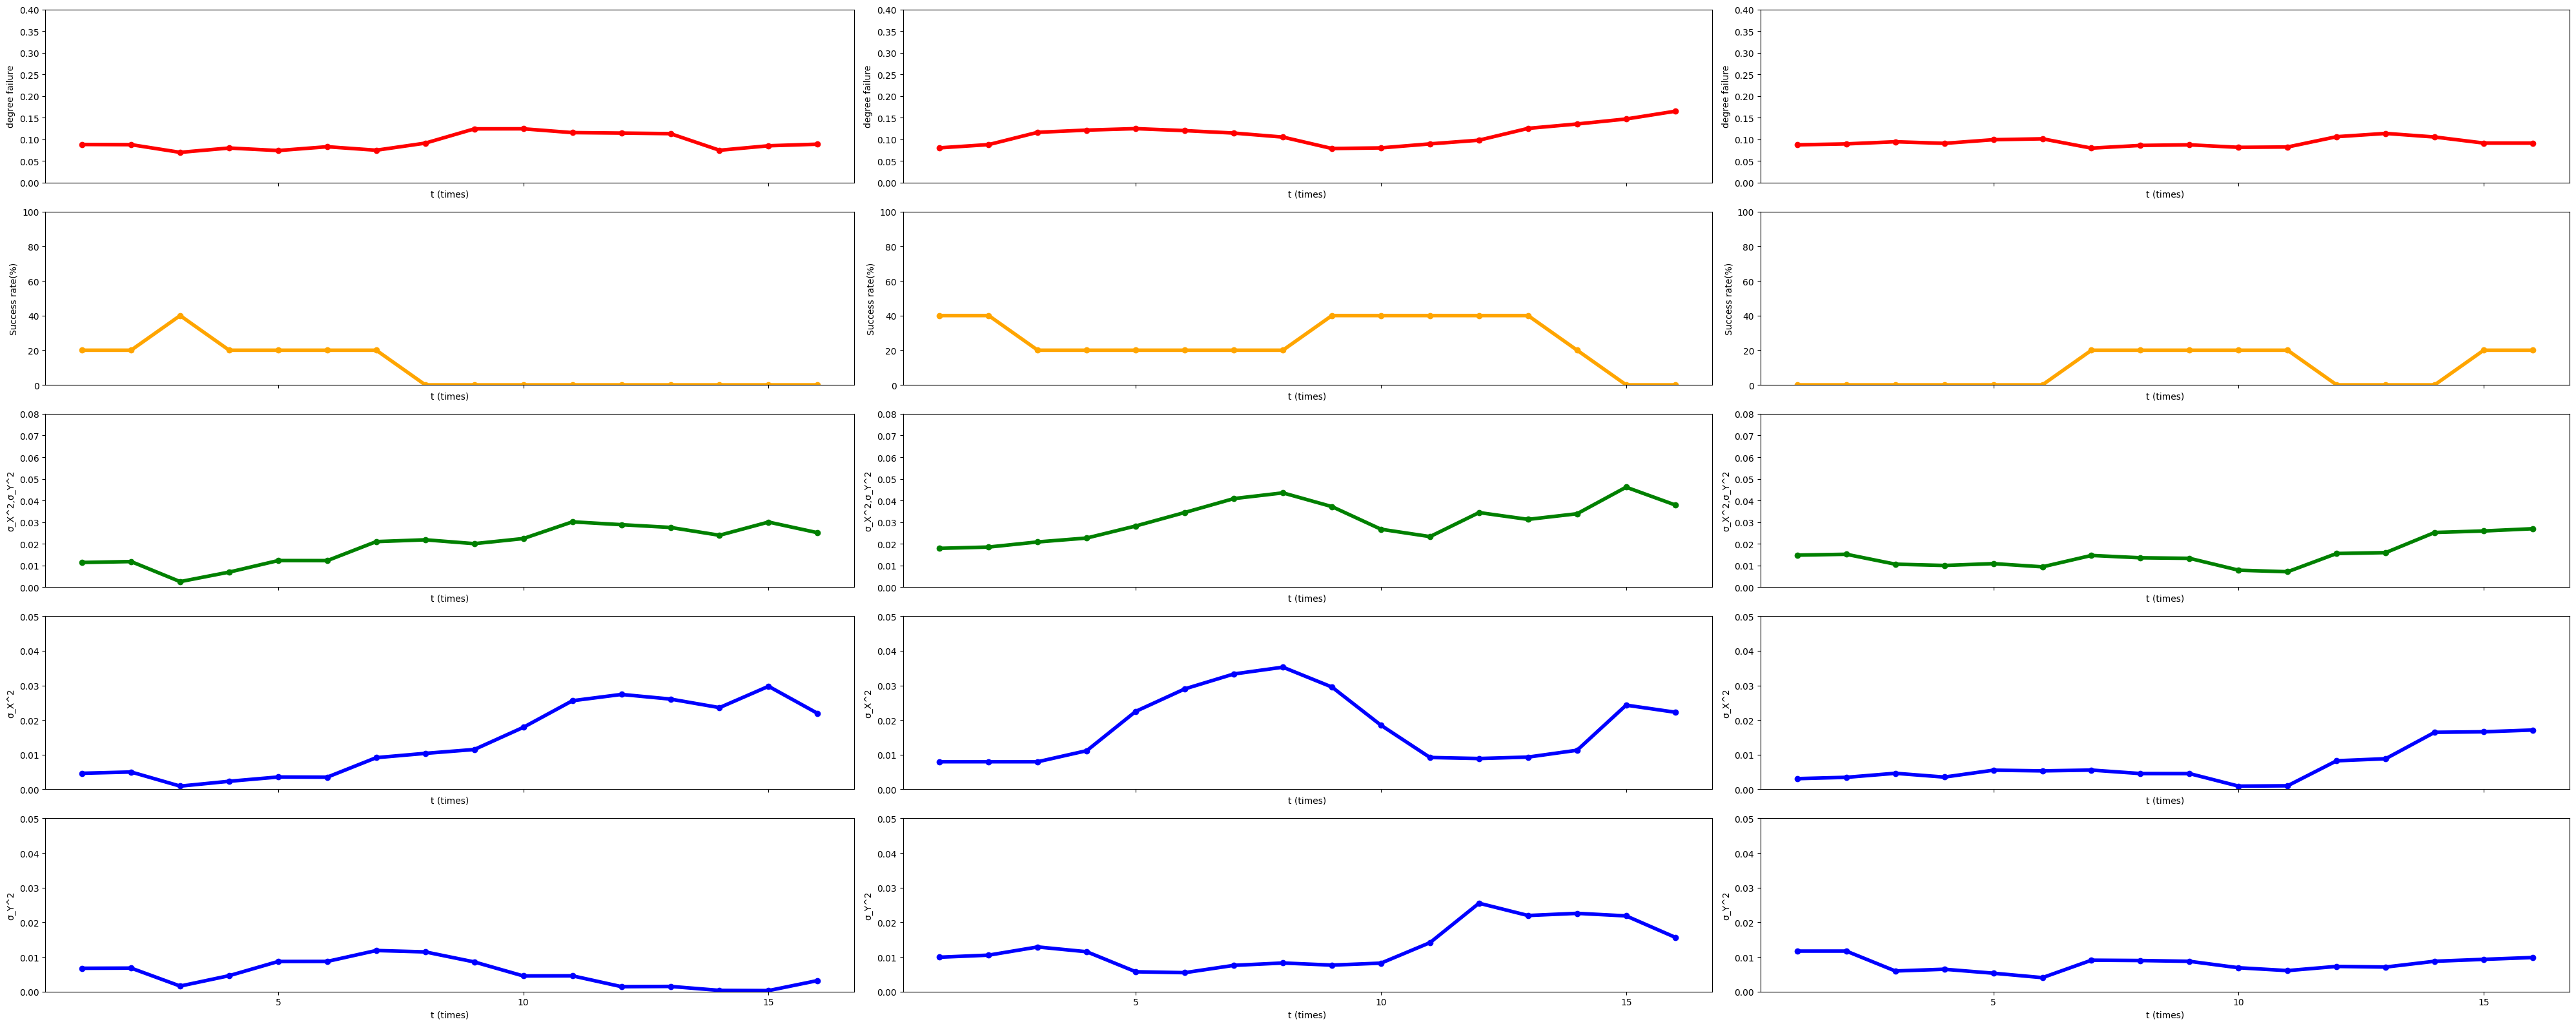

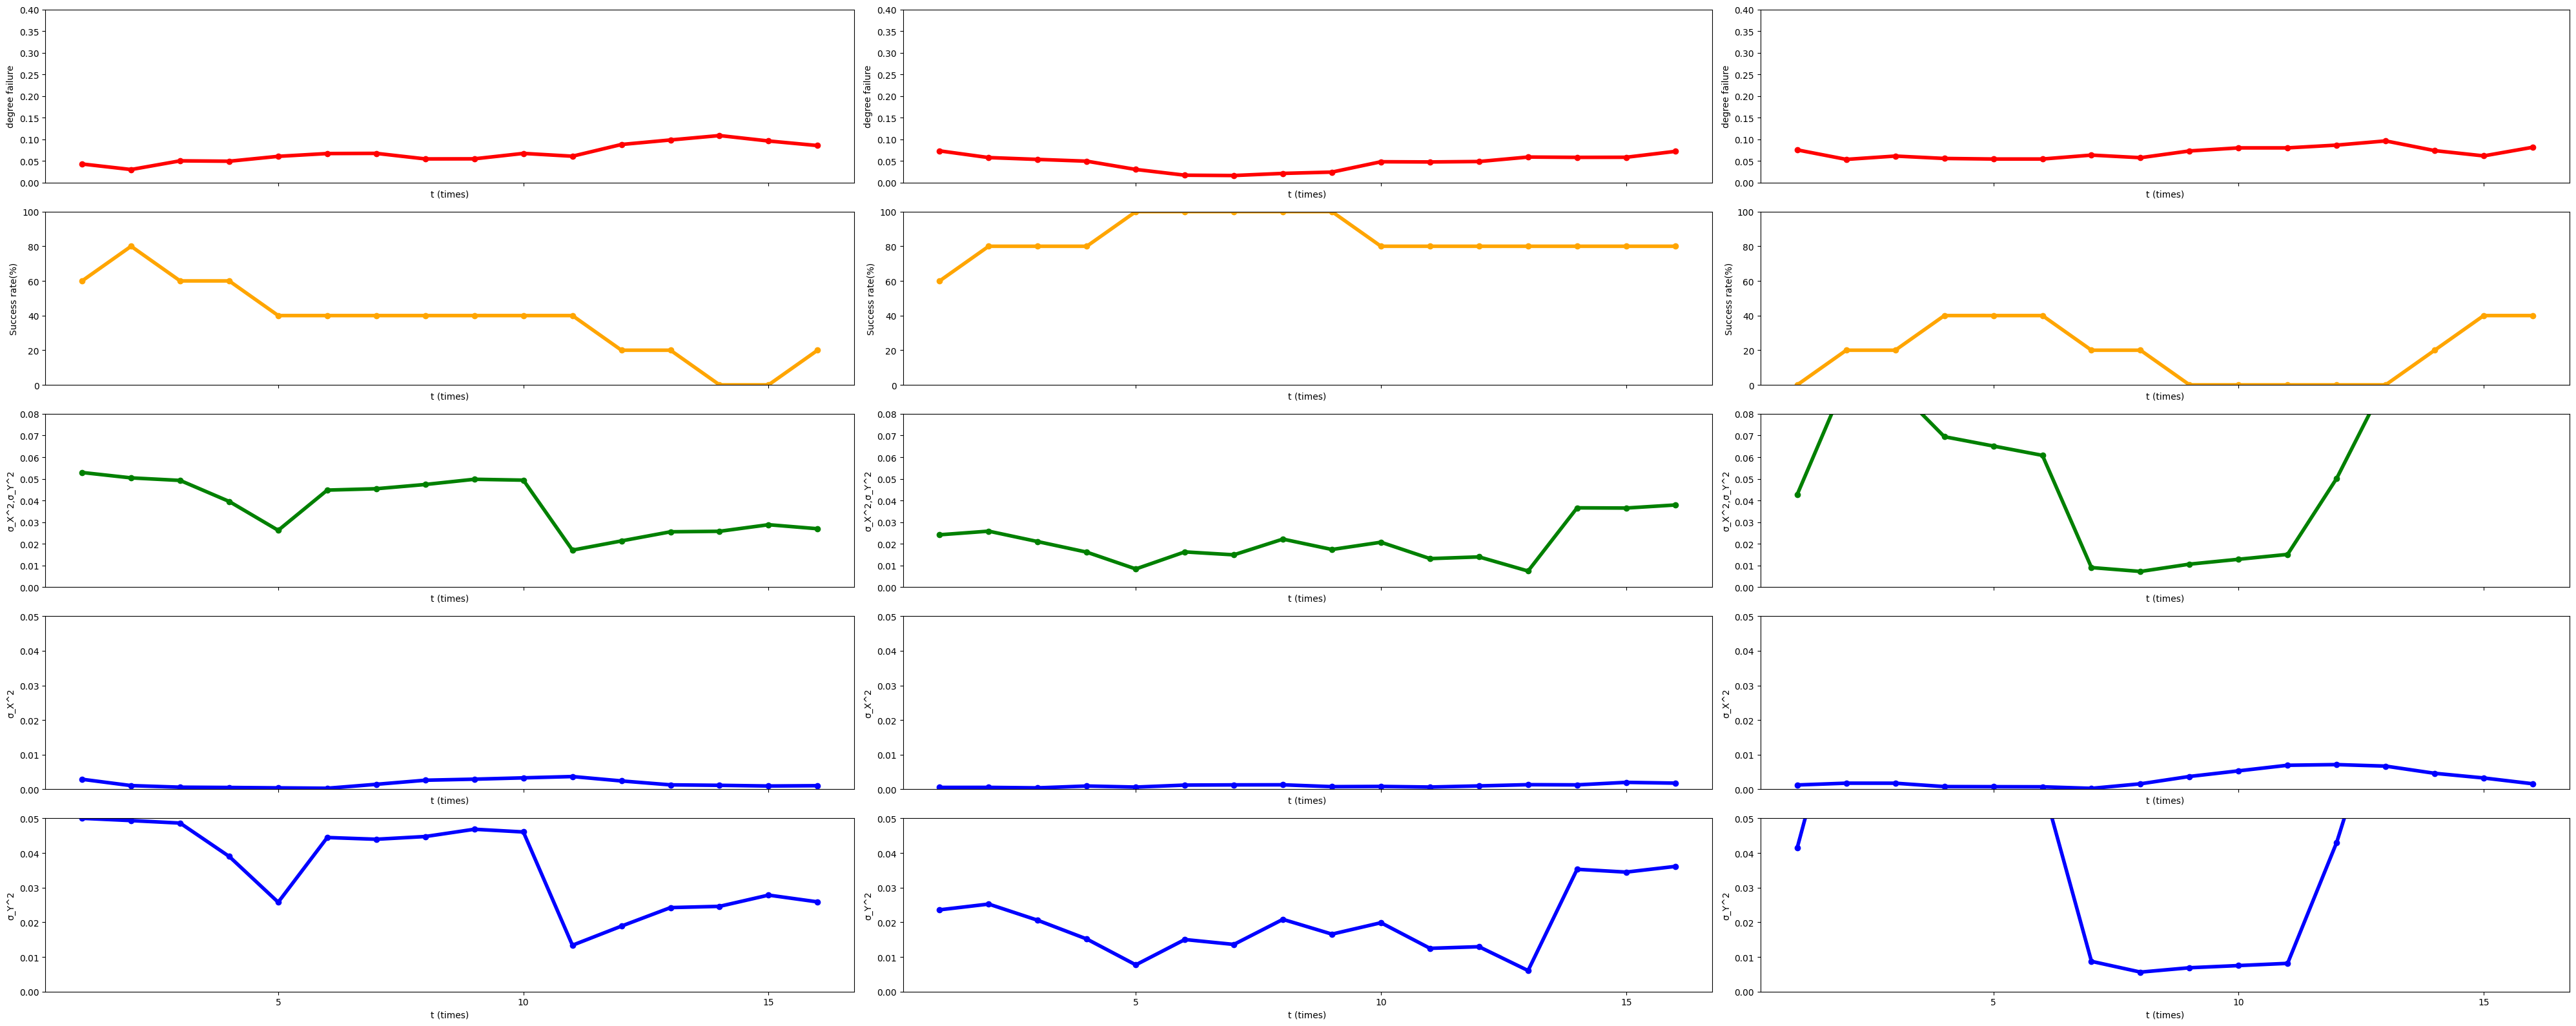

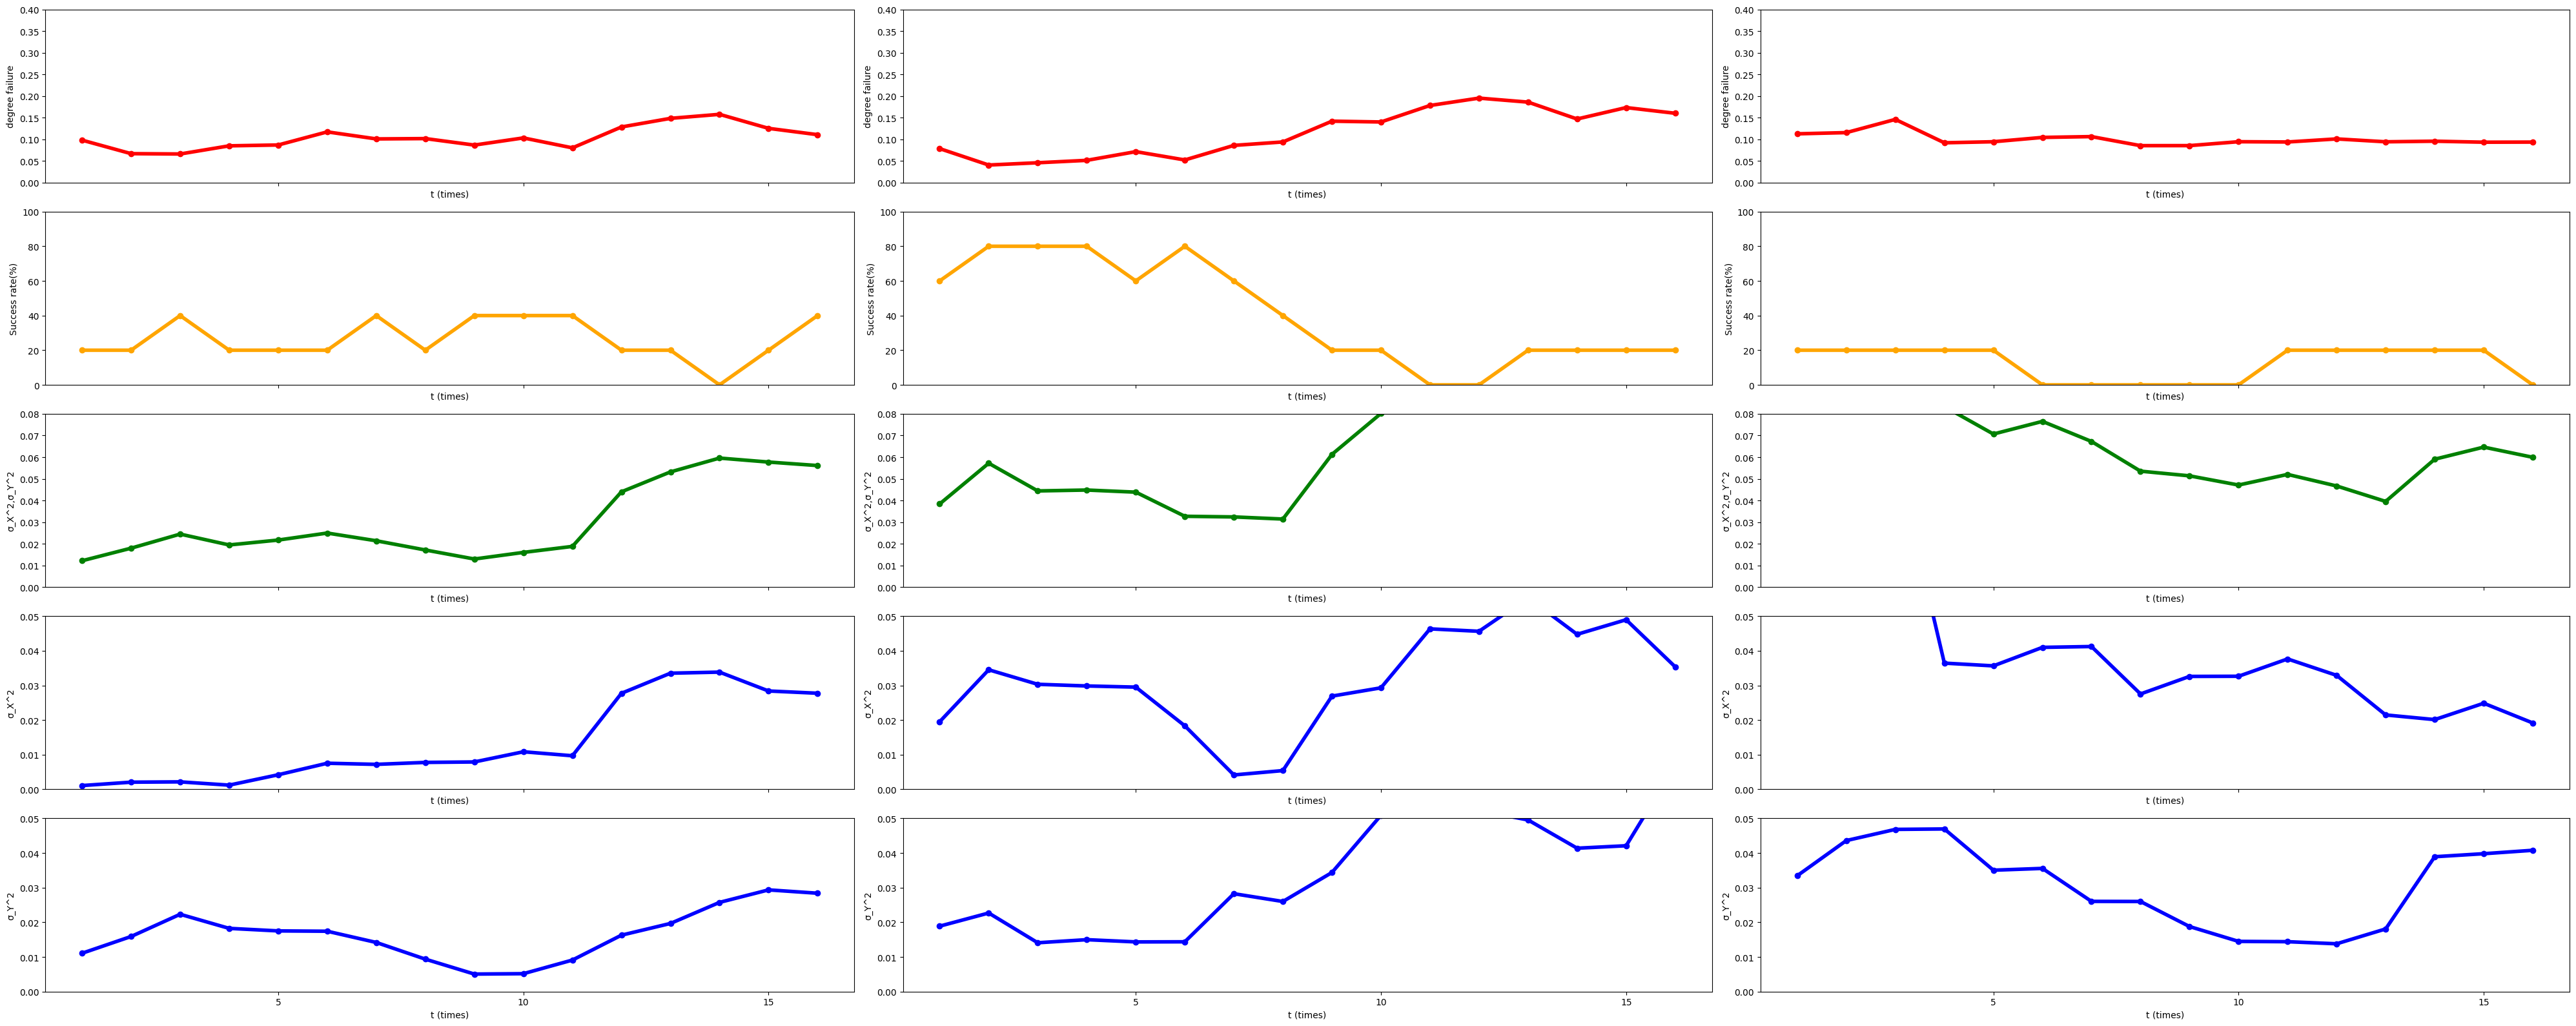

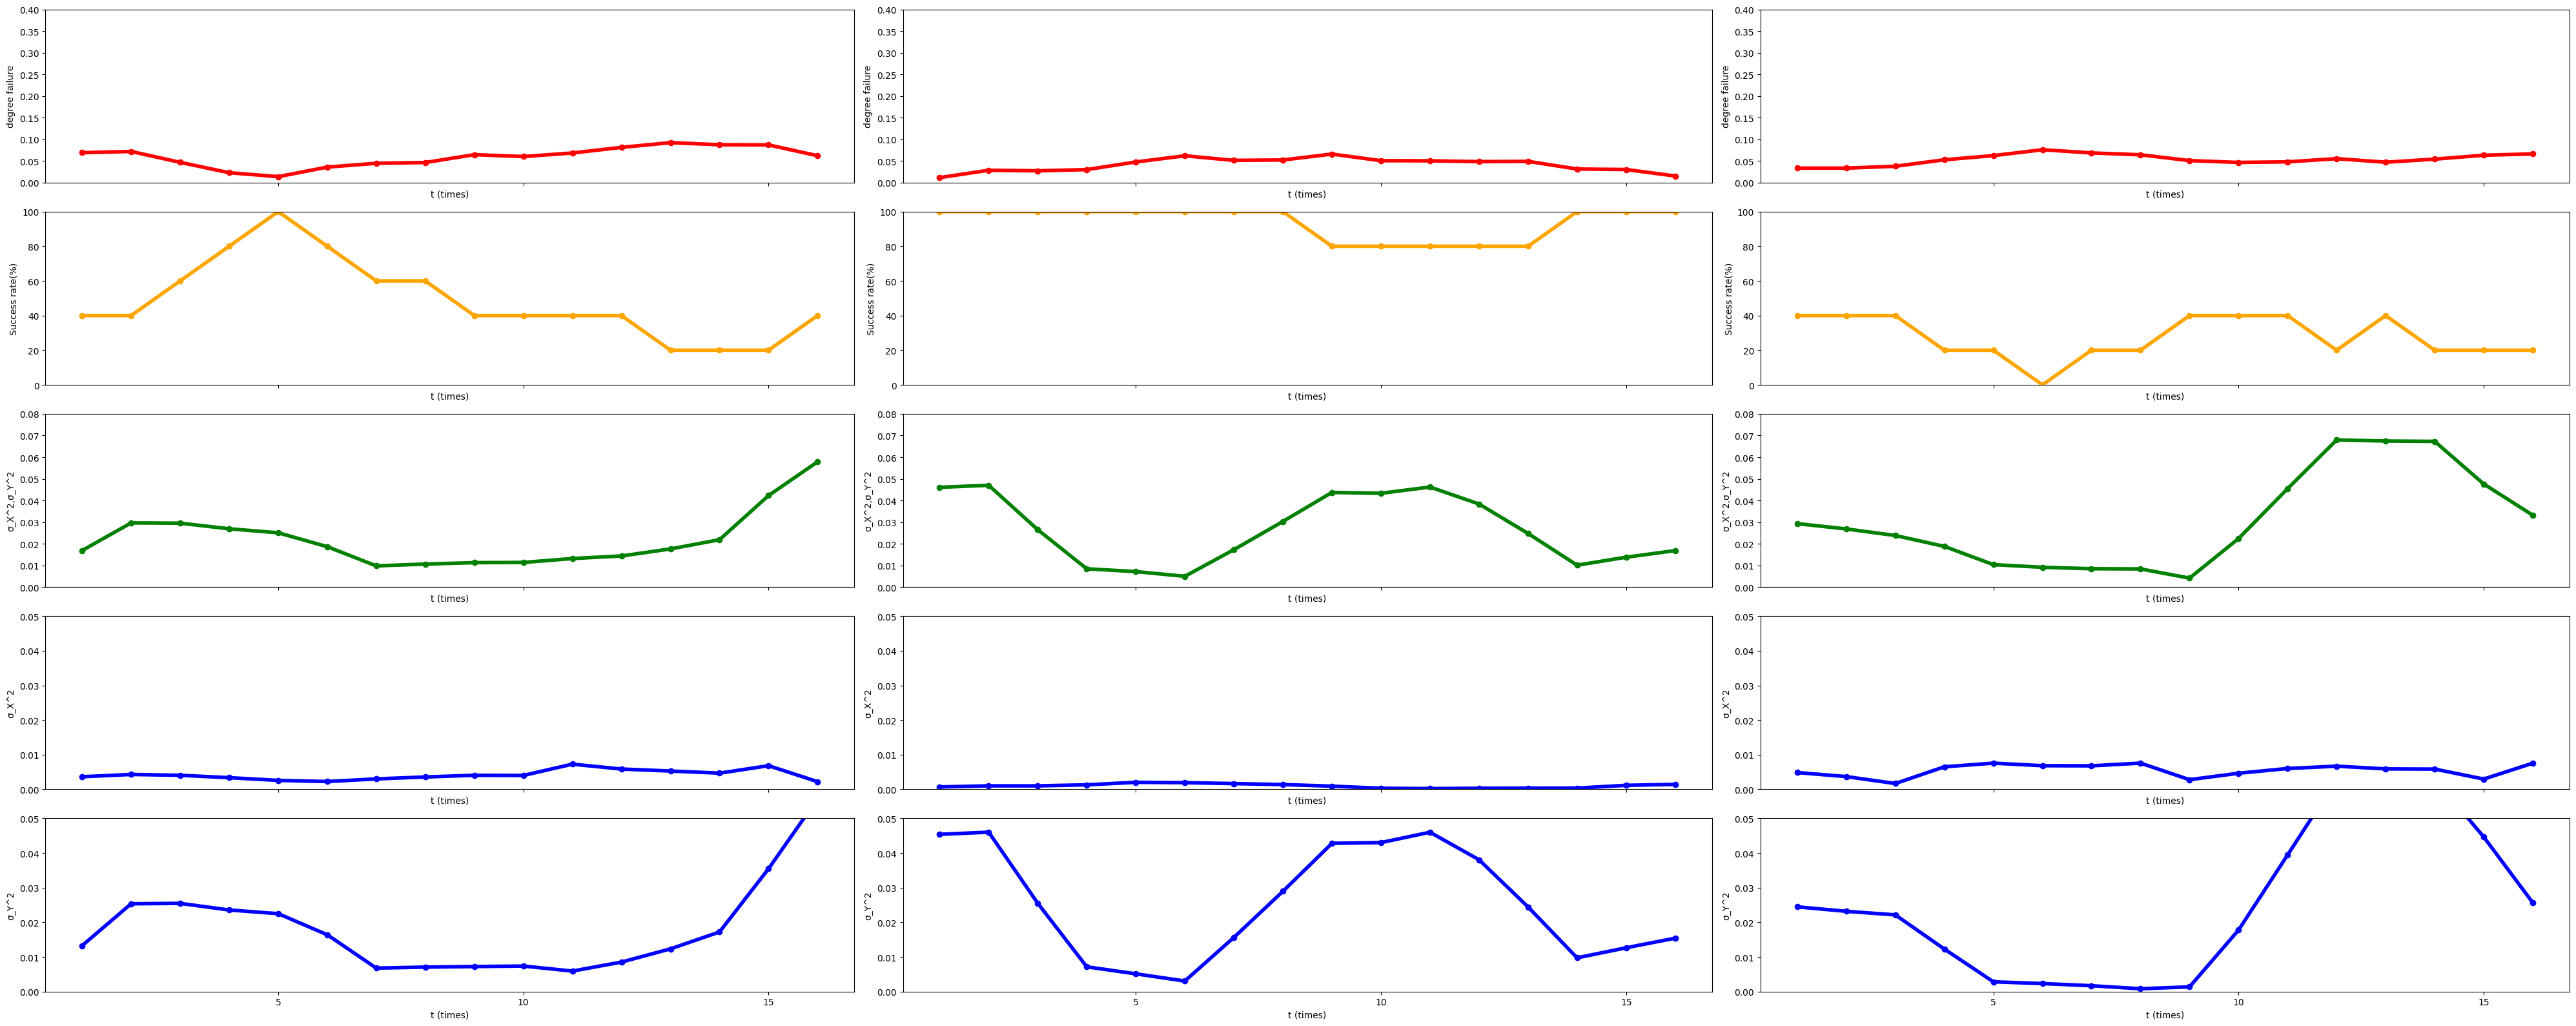

In [8]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 5
difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L = inamura_data_show.make_result(difficulty_levels, division, "divided", width)
column = 5
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 0)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 3)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 6)
inamura_data_show.show_result(A_x_L, A_p_L, A_dispersion_L, A_Abs_degree_failure_L, A_srate_L, column, division, width, 9)

ここ以降は、グラフデータを辞書形式で管理してみたコード \\
一つのグラフに幾つかの被験者のグラフをまとめてみる \\
成功率ごとと分散ごとのグラフを作れる関数を作っておく \\
データを取るタイミングの再確認(Excelでも確認してみる) ←これに取り組んでいる \\

In [9]:
class Kendama_analyze():
  def __init__(self, original_pattern, number_people):
    self.original_pattern = original_pattern #ファイルのリンクを格納
    self.number_people = number_people #どれだけのデータ数を使用するかを決定する変数
    self.threshold = {
        'easy': 0.092,
        'normal': 0.07,
        'hard' : 0.048
    }

  #被験者一人の解析を行う関数
  def start_analyze(self, Kendama_file_path,division, pattern):
    #成功した時と失敗した時の処理を行うコード
    dispersion = np.empty((0,2))     #被験者のやる気を表す分散を格納する配列
    Abs_degree_failure = np.array([])
    x = np.array([])  #試行回数を格納
    success = 0
    srate = np.array([])
    succ_check = True
    abs_degree_failure_sum = 0
    variance_x_sum = 0
    variance_y_sum = 0
    success_sum = 0
    #最初のデータに不備があった時ように初期値の代入
    abs_degree_failure = 0
    variance_x = 0.01
    variance_y = 0.01
    #他の初期値の宣言を書く（abs_degree_failureなど）
    difficult = ""
    for i in range(len(Kendama_file_path)):
      data_check = True #dataが正しいのかのチェックを行う。もし、おかしければ１つ前の施工データを使用するようにする
      if "fail" in Kendama_file_path[i]:
        succ_check = False
      else:
        succ_check = True
      df=pd.read_csv(Kendama_file_path[i],engine='python') #CSVファイルのパスを指定

      if "easy" in Kendama_file_path[i]:
        difficult = "easy"
      elif "normal" in Kendama_file_path[i]:
        difficult = "normal"
      elif "hard" in Kendama_file_path[i]:
        difficult = "hard"

      for index, row in df.iterrows(): #1行目から順番に内容を取得している処理
        if i == 0:
          p = np.array([[row['sword.Position.x'],row['sword.Position.y']]]) #皿のガウス分布の平均値を格納する配列
        if succ_check: #成功した時
          if 0 < row['ball.Position.y'] - row['sword.Position.y'] <= 0.1 and row['ball.Velocity.y'] < 0: #玉がplateに乗っているもしくは直前かどうか
            if abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) <= self.threshold[difficult]:
              data_check = False
              p = np.append(p, [[row['sword.Position.x'],row['sword.Position.y']]], axis = 0) #plateの原点を次回の平均値に入れる
              abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
              abs_degree_failure_sum += abs_degree_failure
              variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y = (row['sword.Position.y']-p[i][1])**2
              variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y_sum += variance_y
              success_sum += 1
              # sigma = sigma/alpha
              break
        else: #失敗した時
          if -0.4 < row['ball.Position.y'] - row['sword.Position.y'] < 0 and row['ball.Velocity.y'] < 0: #玉がplateに乗っているもしくは直前かどうか、そもそも剣よりも上にいっていない場合は論外なので最高到達点が落下地点と一旦考える。※最高到達点の時に皿に近い場合は考えていない
            if abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) > self.threshold[difficult]:
              data_check = False
              p = np.append(p, [[row['ball.Position.x'],row['ball.Position.y']]], axis = 0) #玉の落下位置を次回の平均値に入れる
              abs_degree_failure = abs(np.sqrt((row['ball.Position.x'] - row['sword.Position.x'])**2 + (row['ball.Position.z'] - row['sword.Position.z'])**2)) #皿の中心と落下位置の差（絶対値）
              abs_degree_failure_sum += abs_degree_failure
              variance_x = (row['sword.Position.x']-p[i][0])**2 #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y = (row['sword.Position.y']-p[i][1])**2 #このコードは分散とは言えない
              variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
              variance_y_sum += variance_y
              # sigma = sigma*beta
              break
      if data_check: #dataに何らかの不備があった場合の応急処置のコード
        p = np.append(p, [p[i]], axis = 0)
        if succ_check:
          abs_degree_failure = self.threshold[difficult]-0.001
        else:
          abs_degree_failure = self.threshold[difficult]+0.01
        abs_degree_failure_sum += abs_degree_failure
        variance_x_sum += variance_x #分散を求める一般的な公式である、データから平均を引いて２乗した値を分散にした（値は１つしか使わないので１で割る）←正確に行うなら、一定の差の高さの時の値を全て使うとおそらく良い
        variance_y_sum += variance_y

      if (i+1)%division == 0: #divisionによっていくつごとに平均を取るか決まる
        dispersion = np.append(dispersion, [[variance_x_sum/division,variance_y_sum/division]], axis=0)
        Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure_sum/division)
        abs_degree_failure_sum = 0
        variance_x_sum = 0
        variance_y_sum = 0
        #divisionが１だと0％か１００％になるため例外処理を埋め込んでいる
        if division != 1 or pattern != "default":
          srate = np.append(srate, (success_sum/division)*100)
          success_sum = 0
        else:
          srate = np.append(srate, (success_sum/(i+1))*100)
        x =np.append(x, (i+1)//division)

    # x.append(len(Kendama_file_path))
    p = np.delete(p, 0, axis=0)
    return x,p,dispersion,Abs_degree_failure,srate

  #指定した幅での平均を使った解析 ※width=0の時の例外処理が必要そう
  def divided_analyze(self, division, width, pattern, difficulty_levels):
    data = []
    A_x_L = np.empty((0,int(20-width+1)))
    A_p_L = np.empty((0,20-width+1,2))
    A_dispersion_L = np.empty((0,int(20-width+1),2))
    A_Abs_degree_failure_L = np.empty((0,int(20-width+1)))
    A_srate_L = np.empty((0,int(20-width+1)))
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1から10までの数字でループ
      for level in difficulty_levels[f'{j}']:
        # new_number = '{:02d}'.format(i)  # 2桁の数字にフォーマット
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')  # 数字部分を置換
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path) #ファイルの順番がおかしいので並び替えを行うコード

        x,p,dispersion,Abs_degree_failure,srate = self.start_analyze(Kendama_file_path, division, pattern)

        #新しい配列に1つずつずらした5つの値の平均を入れる
        new_x = x[0:(len(x)-width+1)]
        new_p = np.array([np.mean(p[i:i+width, :], axis=0) for i in range(20-width+1)])
        new_dispersion = np.array([np.mean(dispersion[i:i+width, :], axis=0) for i in range(20-width+1)])
        new_Abs_degree_failure = np.array([np.mean(Abs_degree_failure[i:i+width]) for i in range(20-width+1)])
        #確率は要修正（divisionが１の場合累計の成功率になっているため）
        new_srate = np.array([np.mean(srate[i:i+width]) for i in range(20-width+1)])

        #辞書行列にデータを代入
        data.append({
                'person': j,
                'level': level,
                'x': new_x,
                'p': new_p,
                'dispersion': new_dispersion,
                'Abs_degree_failure': new_Abs_degree_failure,
                'srate': new_srate
            })
    #可視化しやすいようにデータフレーム型に
    df = pd.DataFrame(data)

    return df

  #指定した人数分解析のループを行う関数
  def loop_analyze(self, division, pattern, difficulty_levels):
    data = []
    #difficulty_levels = ['easy', 'normal', 'hard']
    for j in range(1, self.number_people+1):  # 1からnumber_peopleまでの数字でループ
      for level in difficulty_levels[f'{j}']: #fはフォーマットでjの値を入れている
        new_pattern = self.original_pattern.replace('id01_normal', f'id{j:02d}_{level}')
        Kendama_file_path = glob.glob(new_pattern)
        Kendama_file_path = sorted(Kendama_file_path)  # ファイルの順番を並び替え

        x, p, dispersion, Abs_degree_failure, srate = self.start_analyze(Kendama_file_path, division, pattern)

        data.append({
                'person': j,
                'level': level,
                'x': x,
                'p': p,
                'dispersion': dispersion,
                'Abs_degree_failure': Abs_degree_failure,
                'srate': srate
            })

    df = pd.DataFrame(data)

    return df


In [10]:
class Kendama_show(Kendama_analyze):
  def __init__(self, original_pattern, number_people):
    super().__init__(original_pattern, number_people)
    self.colors = {
    'srate': 'orange',
    'abs': 'r',
    'dispersion': 'b',
    'R': 'g'
    }

  def make_result(self, difficulty_levels ,division, pattern, width=None):
    if pattern == "default":
      df_analyze = self.loop_analyze(division, pattern, difficulty_levels)
      return df_analyze
    else:
      df_divided = self.divided_analyze(division, width,pattern, difficulty_levels)
      return df_divided

  def show_result(self, df, column, division, width, difficulty_levels):
    difficulty_colors = {
        'easy': 'b',
        'normal': 'g',
        'hard': 'red'}
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": df['Abs_degree_failure'], "color": 'r', "ylabel": 'degree failure', "ylim": (0, 0.3)},
        "Success rate(%)": {"data": df['srate'], "color": 'orange', "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X^2,σ_Y^2": {"data": df['dispersion'].apply(lambda x: abs(x[:, 0] + x[:, 1])), "color": 'green', "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.08)},
        "σ_X^2": {"data": df['dispersion'].apply(lambda x: x[:, 0]), "color": 'b', "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": df['dispersion'].apply(lambda x: x[:, 1]), "color": 'b', "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column*self.number_people, len(difficulty_levels['1']), figsize=(40, column*self.number_people*5+1))

    for i in range(self.number_people):
      for k in range(len(difficulty_levels['1'])):
        df_filtered = df[(df['person'] == i+1) & (df['level'] == difficulty_levels[f'{i+1}'][k])]
        for j, (label, props) in enumerate(data_dict.items()):
          if j >= column:
            break
          axs[j+i*column, k].plot(df_filtered['x'].values[0], props["data"][df_filtered.index].values[0], linewidth=4, color=props["color"], marker="o")
          axs[j+i*column, k].set_ylabel(props["ylabel"])
          axs[j+i*column, k].set_ylim(props["ylim"])
          axs[j+i*column, k].set_xticks(list(range(5, len(df_filtered['x'].values[0]), 5)))

          # if division == 5:
          #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
          # else:
          #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1

          if j == 0:
            axs[j+i*column, k].axhline(y = self.threshold[difficulty_levels[f'{i+1}'][k]], color =difficulty_colors[difficulty_levels[f'{i+1}'][k]], linestyle = '--')
          axs[j+i*column, k].set_xlabel("t (times)")
          axs[j+i*column, k].set_title(f"person{i+1} {difficulty_levels[f'{i+1}'][k]}", fontsize = 18)

    plt.tight_layout()
    #plt.savefig(f"data_fitting_ajustment.png")
    #files.download(f'data_fitting_ajustment.png')
    plt.show()

  def show_compare(self, df, column, division, width, difficulty_levels, number_list):
    number_colors ={
        1: 'r',
        2: 'g',
        3: 'b',
        4: 'orange',
        5: 'darkviolet',
        6: 'pink',
        7: 'black',
        8: 'cyan',
        9: 'magenta'
    }
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": df['Abs_degree_failure'], "ylabel": 'degree failure', "ylim": (0, 0.3)},
        "Success rate(%)": {"data": df['srate'], "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X^2,σ_Y^2": {"data": df['dispersion'].apply(lambda x: abs(x[:, 0] + x[:, 1])), "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.08)},
        "σ_X^2": {"data": df['dispersion'].apply(lambda x: x[:, 0]), "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": df['dispersion'].apply(lambda x: x[:, 1]), "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column*len(number_list), len(difficulty_levels['1']), figsize=(40, column*len(number_list)*5+1))

    for i in range(len(number_list)):
      for number in number_list[i]:
        for k in range(len(difficulty_levels[f'{number}'])):
          df_filtered = df[(df['person'] == number) & (df['level'] == difficulty_levels[f'{number}'][k])]
          for j, (label, props) in enumerate(data_dict.items()):
            #columnは表示したい値の量を表す変数でcolumnを超えたら新しい被験者のグラフを表示するようにしている
            if j >= column:
              break
            axs[j+i*column, k].plot(df_filtered['x'].values[0], props["data"][df_filtered.index].values[0], color = number_colors[number], linewidth=4)
            axs[j+i*column, k].set_ylabel(props["ylabel"])
            axs[j+i*column, k].set_ylim(props["ylim"])
            axs[j+i*column, k].set_xticks(list(range(5, len(df_filtered['x'].values[0]), 5)))

            # if division == 5:
            #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
            # else:
            #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1

            axs[j+i*column, k].set_xlabel("t (times)")
            axs[j+i*column, k].set_title(f"{difficulty_levels[f'{number}'][k]}", fontsize=18)

    plt.tight_layout()
    #plt.savefig(f"data_fitting_ajustment.png")
    #files.download(f'data_fitting_ajustment.png')
    plt.show()

  def show_compare_person(self, df, column, division, width, difficulty_levels):
    difficulty_colors = {
        'easy': 'b',
        'normal': 'g',
        'hard': 'red'}
    # 各データのラベルと色の辞書
    data_dict = {
        "degree failure": {"data": df['Abs_degree_failure'], "color": 'r', "ylabel": 'degree failure', "ylim": (0, 0.3)},
        "Success rate(%)": {"data": df['srate'], "color": 'orange', "ylabel": 'Success rate(%)', "ylim": (0, 100)},
        "σ_X,σ_Y": {"data": df['dispersion'].apply(lambda x: abs(x[:, 0] + x[:, 1])), "color": 'green', "ylabel": 'σ_X^2,σ_Y^2', "ylim": (0, 0.08)},
        "σ_X^2": {"data": df['dispersion'].apply(lambda x: x[:, 0]), "color": 'b', "ylabel": 'σ_X^2', "ylim": (0, 0.05)},
        "σ_Y^2": {"data": df['dispersion'].apply(lambda x: x[:, 1]), "color": 'b', "ylabel": 'σ_Y^2', "ylim": (0, 0.05)}

    }

    fig, axs = plt.subplots(column, self.number_people, figsize=(80, column*5+1), sharex="col", sharey="row")

    for i in range(self.number_people):
      for k in range(len(difficulty_levels['1'])):
        df_filtered = df[(df['person'] == i+1) & (df['level'] == difficulty_levels[f'{i+1}'][k])]
        for j, (label, props) in enumerate(data_dict.items()):
          if j >= column:
            break
          axs[j, i].plot(df_filtered['x'].values[0], props["data"][df_filtered.index].values[0], color =difficulty_colors[difficulty_levels[f'{i+1}'][k]], linewidth=4, marker="o")
          if i == 0:  # 最初の1列目の場合のみY軸ラベルを設定
            axs[j, i].set_ylabel(props["ylabel"], fontsize = 36)
          axs[j, i].set_ylim(props["ylim"])

          # if division == 5:
          #   axs[j, i].set_xticks(np.arange(1, 5*division+1, division))  # [1, 2, 3, 4] if division=5
          # else:
          #   axs[j, i].set_xticks(np.arange(5, max(A_x_L[i])+1, 5*division))  # [5, 10, 15, 20] if division=1
          if j == 0:
            axs[j, i].set_title(f"id0{i+1}", fontsize = 36)
            axs[j, i].set_xticks(list(range(5, len(df_filtered['x'].values[0]), 5)))
            axs[j, i].axhline(y = self.threshold[difficulty_levels[f'{i+1}'][k]], color =difficulty_colors[difficulty_levels[f'{i+1}'][k]], linestyle = '--')
          if j == column-1:
            axs[j, i].set_xlabel("t (times)", fontsize = 36)

    plt.tight_layout()
    # plt.savefig(f"data_fitting_person.pdf")
    # files.download(f'data_fitting_person.pdf')

    plt.show()


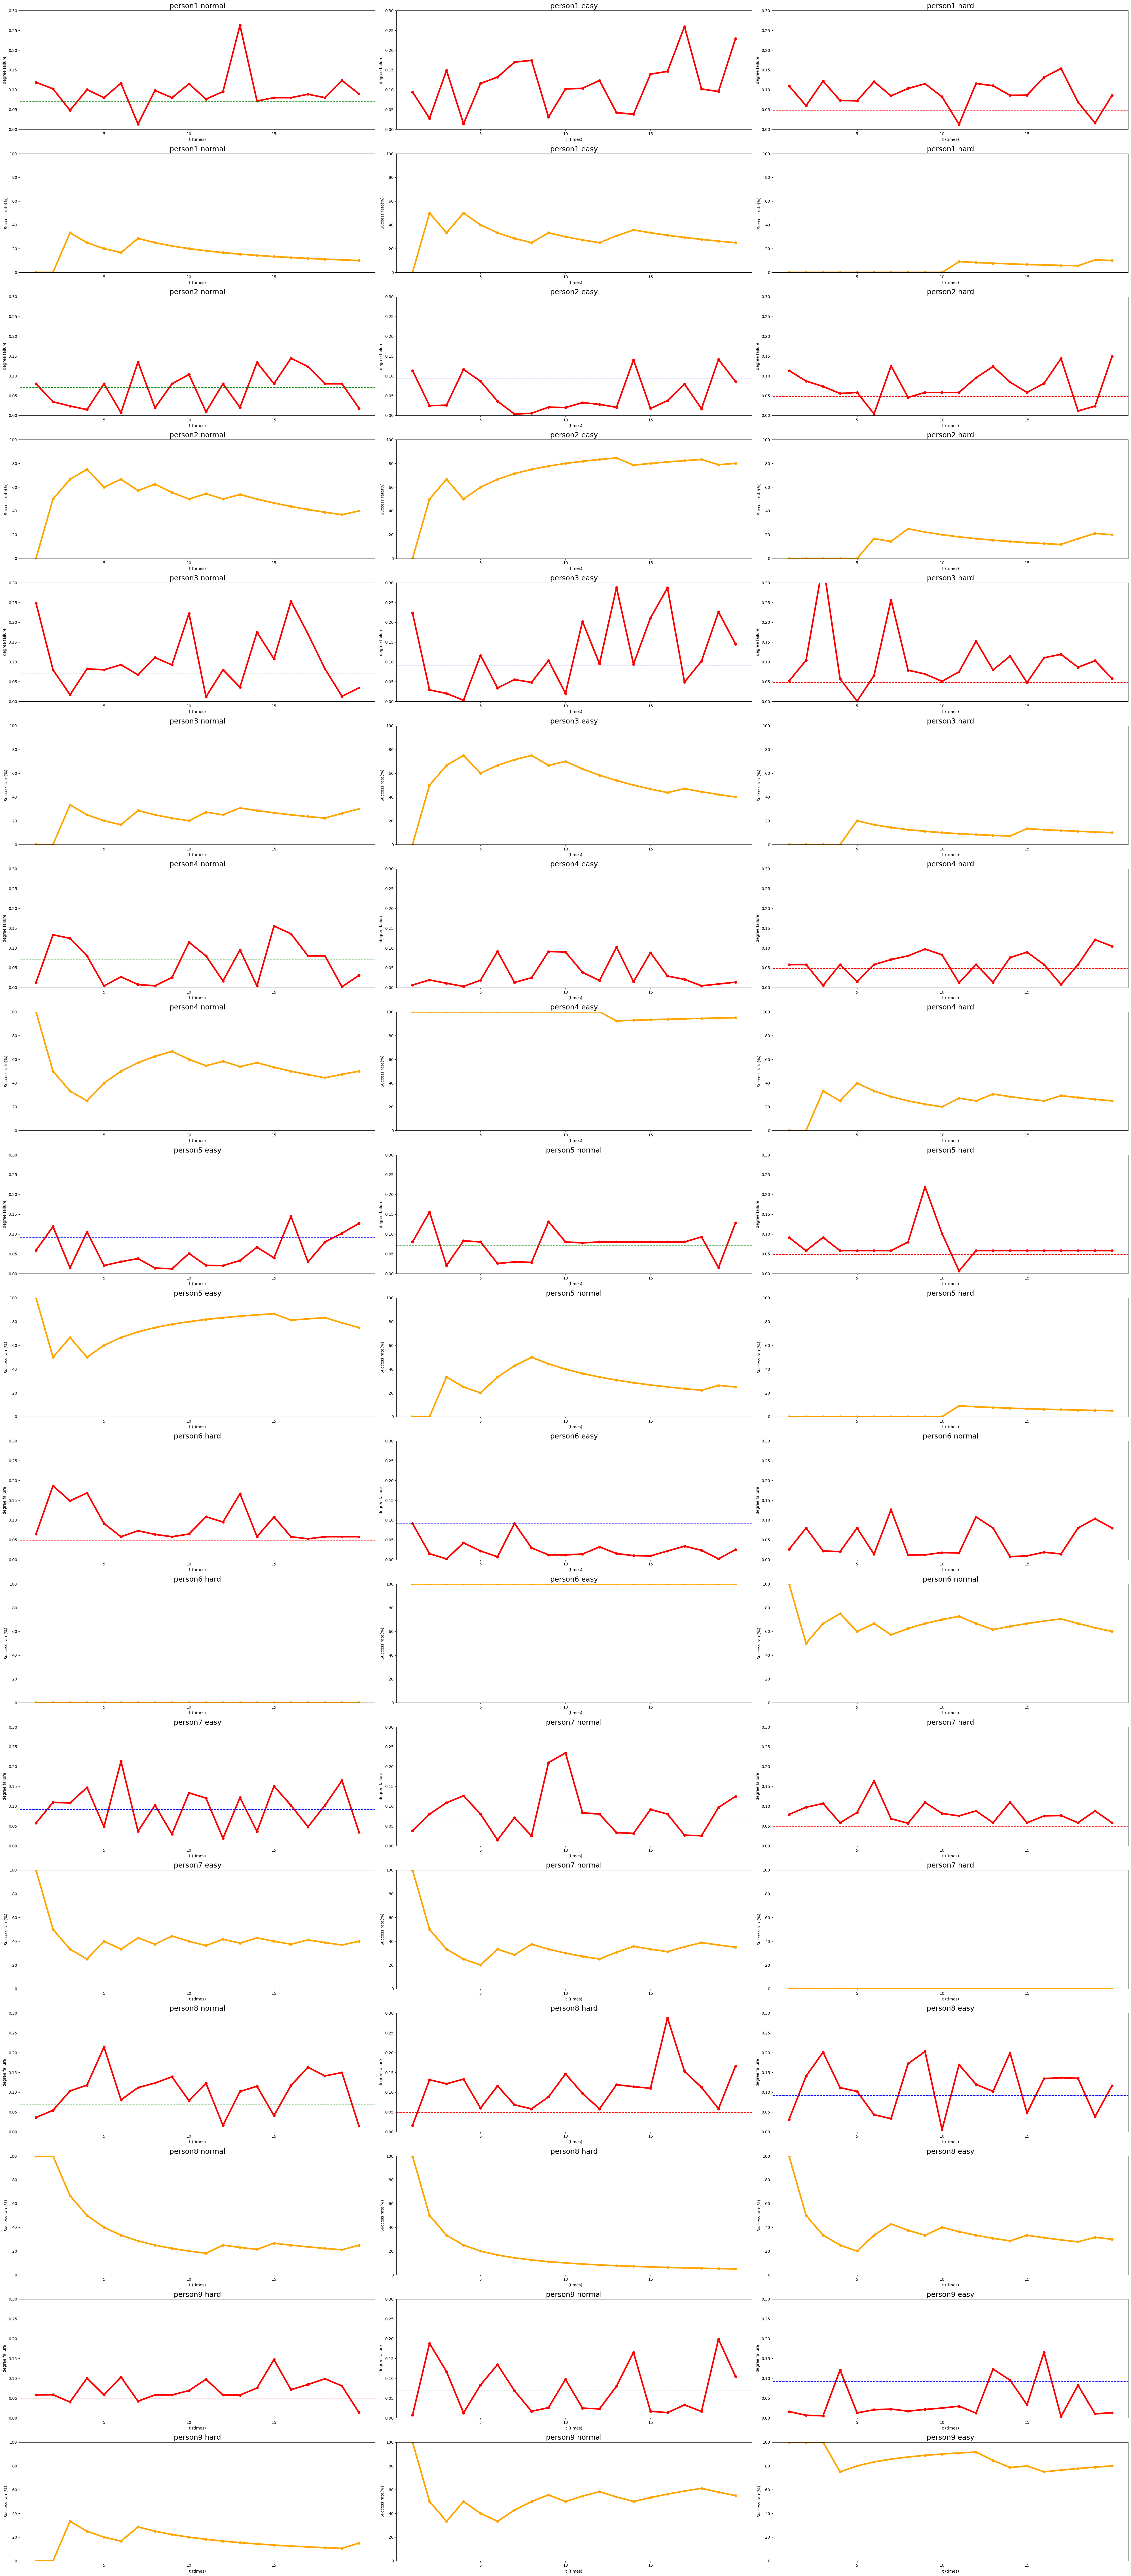

In [11]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 0
difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
df_analyze = inamura_data_show.make_result(difficulty_levels, division, "default")
column = 2
inamura_data_show.show_result(df_analyze, column, division, width, difficulty_levels)

In [12]:
# width = 0
# column = 2
# number_list = [[1,2,3,4],[5,7]]
# inamura_data_show.show_compare(df_analyze, column, division, width, difficulty_levels, number_list)

In [13]:
# original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
# number_people = 9
# inamura_data_show = Kendama_show(original_pattern, number_people)
# division = 1
# width = 0
# difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
# df_analyze = inamura_data_show.make_result(difficulty_levels, division, "default")
# column = 3
# inamura_data_show.show_compare_person(df_analyze, column, division, width, difficulty_levels)

In [14]:
# original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
# number_people = 9
# difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
# inamura_data_show = Kendama_show(original_pattern, number_people)
# division = 1
# width = 5
# df_divided = inamura_data_show.make_result(difficulty_levels, division, "divided", width)
# column = 3
# inamura_data_show.show_result(df_divided, column, division, width, difficulty_levels)

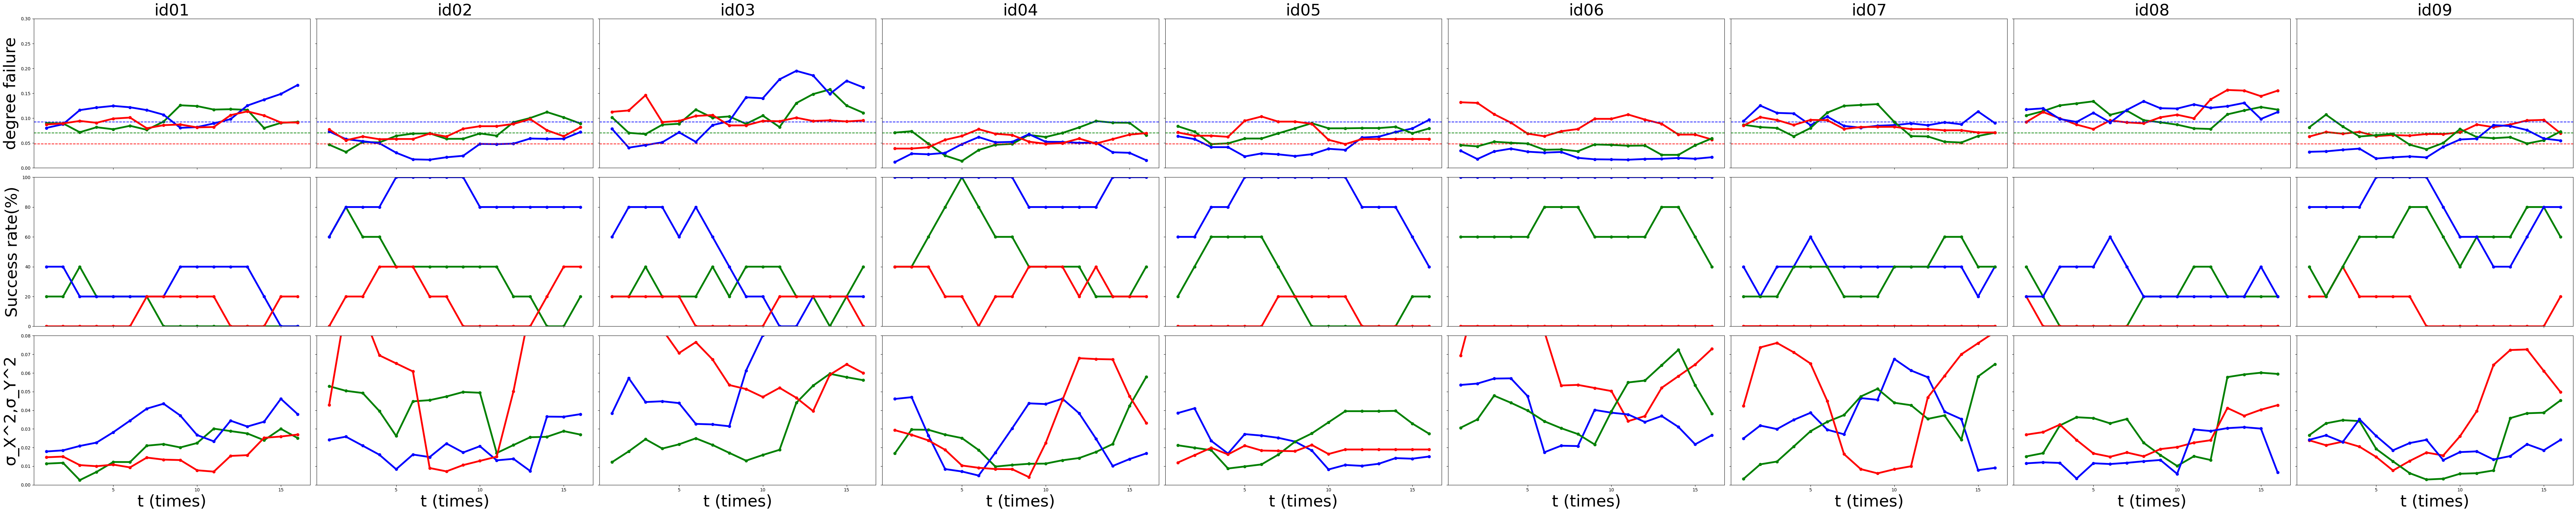

In [15]:
original_pattern = '/content/drive/MyDrive/kendama_202210_202305_inamura/id01_normal/*.csv'
difficulty_levels = {'1': ['normal', 'easy', 'hard'], '2':['normal', 'easy', 'hard'], '3': ['normal', 'easy', 'hard'], '4': ['normal', 'easy', 'hard'], '5': ['easy', 'normal', 'hard'], '6': ['hard', 'easy', 'normal'], '7': ['easy', 'normal', 'hard'], '8': ['normal', 'hard', 'easy'], '9': ['hard', 'normal', 'easy']}
number_people = 9
inamura_data_show = Kendama_show(original_pattern, number_people)
division = 1
width = 5
df_divided = inamura_data_show.make_result(difficulty_levels, division, "divided", width)
column = 3
inamura_data_show.show_compare_person(df_divided, column, division, width, difficulty_levels)

In [16]:
df_analyze.head()

,person,level,x,p,dispersion,Abs_degree_failure,srate
0,1,normal,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[-0.1712, 1.4378], [-0.2151, 1.5119], [-0.205...","[[0.0, 0.0], [0.021257640000000005, 0.02795584...","[0.11869494513246975, 0.10237016166832989, 0.0...","[0.0, 0.0, 33.33333333333333, 25.0, 20.0, 16.6..."
1,1,easy,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[-0.1508, 1.4936], [-0.1642, 1.5711], [-0.158...","[[0.0, 0.0], [0.00017956000000000062, 0.006006...","[0.09442992110554795, 0.027851391347650897, 0....","[0.0, 50.0, 33.33333333333333, 50.0, 40.0, 33...."
2,1,hard,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[-0.1179, 1.5997], [-0.07, 1.415], [-0.2092, ...","[[0.0, 0.0], [9.000000000000015e-06, 0.0313289...","[0.10971276133613626, 0.05980183943659256, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,normal,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[-0.0346, 1.4434], [-0.089, 1.5057], [-0.0686...","[[0.01, 0.01], [0.00295936, 0.0038812900000000...","[0.08, 0.03445301147940484, 0.0237547889908540...","[0.0, 50.0, 66.66666666666666, 75.0, 60.0, 66...."
4,2,easy,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[-0.124, 1.2541], [-0.0975, 1.4284], [-0.079,...","[[0.0, 0.0], [0.0007022499999999997, 0.0303804...","[0.11333653426852265, 0.02450510150968569, 0.0...","[0.0, 50.0, 66.66666666666666, 50.0, 60.0, 66...."
